<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-bookcamp/6-ensemble-learning/03_credit_risk_scoring_using_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Credit risk scoring project: XGBoost

Imagine that we work at a bank. When we receive a loan application, we need to make
sure that if we give the money, the customer will be able to pay it back. Every application
carries a risk of default — the failure to return the money.

Credit risk scoring is a binary classification problem: the target is positive (“1”) if the
customer defaults and negative (“0”) otherwise.

We will use machine learning to calculate the risk of
default. The plan for the project is the following:

* We will train decision tree model for predicting the probability
of default.
* Then we combine multiple decision trees into one model — a random forest.
* Finally, we explore a different way of combining decision trees — gradient
boosting(XGBoost).

##Setup

In [1]:
import pandas as pd
import numpy as np
import pickle 
import requests

from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_graphviz, export_text
from graphviz import Source

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!wget https://github.com/rahiakela/machine-learning-research-and-practice/raw/main/machine-learning-bookcamp/6-ensemble-learning/credit_scoring.csv

##Dataset

In [3]:
# let’s read our dataset
data_df = pd.read_csv("credit_scoring.csv")
print(len(data_df))
data_df.head()

4455


,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


##Data cleaning

In [4]:
# let’s lowercase all the column names
data_df.columns = data_df.columns.str.lower()
data_df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [5]:
# Let’s handle the categorical column
data_df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [6]:
status_values = {
  1: "ok", 
  2: "default", 
  0: "unk"
}
data_df.status = data_df.status.map(status_values)
data_df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
data_df.home.value_counts()

2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: home, dtype: int64

In [8]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
data_df.home = data_df.home.map(home_values)

In [9]:
data_df.marital.value_counts()

2    3241
1     978
4     130
3      67
5      38
0       1
Name: marital, dtype: int64

In [10]:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
data_df.marital = data_df.marital.map(marital_values)

In [11]:
data_df.records.value_counts()

1    3682
2     773
Name: records, dtype: int64

In [12]:
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
data_df.records = data_df.records.map(records_values)

In [13]:
data_df.job.value_counts()

1    2806
3    1024
2     452
4     171
0       2
Name: job, dtype: int64

In [14]:
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
data_df.job = data_df.job.map(job_values)

In [15]:
data_df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [16]:
# let’s check the summary statistics for each of the columns
data_df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [17]:
# Let’s replace this big number with NaN for these columns
for c in ["income", "assets", "debt"]:
  data_df[c] = data_df[c].replace(to_replace=99999999, value=np.nan) 

In [18]:
data_df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

In [19]:
data_df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [20]:
# let’s look at our target variable status
data_df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [21]:
# this row is not useful, so let’s remove it
data_df = data_df[data_df.status != "unk"]

In [22]:
data_df.status.value_counts()

ok         3200
default    1254
Name: status, dtype: int64

##Dataset preparation

In [23]:
# Let’s start by splitting the data
df_train_full, df_test = train_test_split(data_df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [24]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [25]:
# let's convert label to 0 and 1
y_train = (df_train.status == "default").values
y_val = (df_val.status == "default").values

In [26]:
# Now we need to remove status from the DataFrames.
del df_train["status"]
del df_val["status"]

In [27]:
# let's replace the missing values with zero
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [28]:
# let's convert the DataFrames into dictionaries
dict_train = df_train.to_dict(orient="records")
dict_val = df_val.to_dict(orient="records")

In [29]:
dict_train[0]

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [30]:
# now, let's apply one-hot encoding technique
dv = DictVectorizer(sparse=False)

x_train = dv.fit_transform(dict_train)
x_val = dv.transform(dict_val)

##Gradient boosting

In [31]:
# Let's wrap data into DMatrix
features = dv.get_feature_names_out()

d_train = xgb.DMatrix(x_train, label=y_train, feature_names=features)
d_val = xgb.DMatrix(x_val, label=y_val, feature_names=features)

In [32]:
# let's specify the parameters for training
xgb_params = {
  "eta": 0.3,
  "max_depth": 6,
  "min_child_weight": 1,

  "objective": "binary:logistic",
  "nthread": 8,

  "seed": 1,
  "verbosity": 1
}

In [33]:
# now, let's train model
model = xgb.train(xgb_params, d_train, num_boost_round=10)
y_pred = model.predict(d_val)

In [34]:
y_pred[:10]

array([0.08926772, 0.0468099 , 0.09692743, 0.17261842, 0.05435968,
       0.12576081, 0.08033007, 0.61870354, 0.486538  , 0.04056795],
      dtype=float32)

In [35]:
# To calculate AUC
roc_auc_score(y_val, y_pred)

0.8152745150274878

##Performance monitoring

In [36]:
# let's use a watchlist for monitoring model performance
watchlist = [
  (d_train, "train"), 
  (d_val, "val")
]

In [37]:
%%capture output

xgb_params = {
  "eta": 0.3,
  "max_depth": 6,
  "min_child_weight": 1,

  "objective": "binary:logistic",
  "eval_metric": "auc",

  "nthread": 8,

  "seed": 1,
  "verbosity": 1
}

model = xgb.train(xgb_params, d_train, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [38]:
s = output.stdout
print(s[:200])

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	tr


In [46]:
def parse_xgb_output(output):
  results = []
  for line in output.stdout.strip().split("\n"):
    itr_line, train_line, val_line = line.split("\t")

    itr = int(itr_line.strip("[]"))
    train = float(train_line.split(":")[1])
    val = float(val_line.split(":")[1])
    results.append((itr, train, val))
  
  columns = ["num_iter", "train_auc", "val_auc"]
  df_results = pd.DataFrame(results, columns=columns)
  return df_results

In [47]:
df_scores = parse_xgb_output(output)

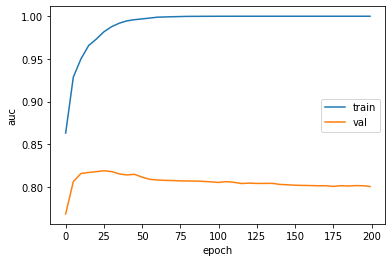

In [51]:
plt.plot(df_scores.num_iter, df_scores.train_auc, label="train")
plt.plot(df_scores.num_iter, df_scores.val_auc, label="val")
plt.xlabel("epoch")
plt.ylabel("auc")
plt.legend()
plt.show()

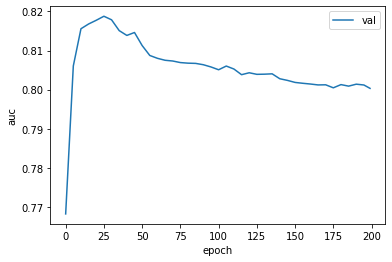

In [52]:
plt.plot(df_scores.num_iter, df_scores.val_auc, label="val")
plt.xlabel("epoch")
plt.ylabel("auc")
plt.legend()
plt.show()

##Parameter tuning

In [ ]:
for depth in [5, 10, 15]:
  df_subset = df_scores[df_scores.max_depth == depth]
  plt.plot(df_subset.n_estimators, df_subset.auc, label=f"max_depth={depth}")
plt.xlabel("n_estimators")
plt.ylabel("auc")
plt.legend()
plt.show()

In [ ]:
# so, let's set default max_depth 
max_depth = 10

In [ ]:
# Let’s find the best min sample leaf parameter
scores = []
for s in [1, 3, 5, 10, 50]:
  for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
    rf.fit(x_train, y_train)
    y_pred = rf.predict_proba(x_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((s, n, auc))

In [ ]:
columns=["min_samples_leaf", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]
list(zip(values, colors))

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for val, color in list(zip(values, colors)):
  df_subset = df_scores[df_scores.min_samples_leaf == val]
  plt.plot(df_subset.n_estimators, df_subset.auc, color=color, label=f"min_samples_leaf={val}")
plt.xlabel("n_estimators")
plt.ylabel("auc")
plt.legend()
plt.show()

In [ ]:
# Let’s create the best final model
min_samples_leaf = 3
scores = []

rf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(x_train, y_train)
y_pred = rf.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(auc)

Other useful parametes:

* max_features
* bootstrap

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html